In [1]:
import pandas as pd
import numpy as np
import pickle

import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

from matplotlib import pyplot as plt

import random
import math
import time

In [2]:
df = pd.read_csv('assets/df_cleaned.csv')

In [3]:
df.head()

,tweet_id,tweet_text,class_label,file_name,event,year,event_type,data_type,tweet_text_cleaned,hashtags,class_label_id,processed_text_length
0,1.065845e+18,"Camp Fire leaves over 13,000 without homes thi...",displaced_people_and_evacuations,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,camp fire leaves over without homes this thank...,[],0,123.0
1,1.061321e+18,"So in a truly strange world, we have @RealJame...",not_humanitarian,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,so in a truly strange world we have playing th...,[],1,148.0
2,1.063536e+18,66 people have died and more than 600 are stil...,injured_or_dead_people,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,people have died and more than are still missi...,"['californiawildfires', 'cafire', 'campfire', ...",2,61.0
3,1.062711e+18,BBC News - California wildfires: Nine dead and...,injured_or_dead_people,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,bbc news california wildfires nine dead and mo...,[],2,63.0
4,1.064808e+18,Death toll in California’s #CampFire has climb...,injured_or_dead_people,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,death toll in californias has climbed to the n...,['campfire'],2,219.0


In [4]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_sie = len(df) - train_size - val_size
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [train_size, train_size + val_size])

In [5]:
len(df_train), len(df_val), len(df_test)

(61186, 7648, 7649)

In [6]:
class BaselineModel(nn.Module):

    def __init__(self, hidden_size, embedding, vocab, n_class, dropout_rate=0):

        super(BaselineModel, self).__init__()

        self.hidden_size = hidden_size
        self.embed_size = embedding.size(1)
        self.vocab_size = embedding.size(0)
        self.vocab = vocab
        self.n_class = n_class
        self.padding_idx = self.vocab['<pad>']
        self.dropout_rate = dropout_rate
        self.device = embedding.device

        self.embedding_layer = nn.Embedding(self.vocab_size, self.embed_size, padding_idx=self.padding_idx)
        self.embedding_layer.weight = nn.Parameter(embedding)
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size, bidirectional=True)
        self.hidden_to_softmax = nn.Linear(self.hidden_size*2, self.n_class, bias=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, sents):

        text_lengths = torch.tensor([len(sent) for sent in sents], device=self.device)
        sents_tensor = self.sents2tensor(sents)  # (max_sent_length, batch_size)
        x_embed = self.embedding_layer(sents_tensor)  # (max_sent_length, batch_size, embed_size)
        seq = pack_padded_sequence(x_embed.float(), text_lengths)
        enc_hiddens, (last_hidden, last_cell) = self.lstm(seq)
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)  # (batch_size, 2*hidden_size)
        output_hidden = self.dropout(output_hidden)
        pre_softmax = self.hidden_to_softmax(output_hidden)  # (batch_size, n_class)

        return pre_softmax
    
    def words2indices(self, sents):
        return [[self.vocab.get(w, self.vocab['<unk>']) for w in s] for s in sents]
    
    def pad_sents(self, sents_token, pad_token):
        sents_padded = []
        max_len = max(len(s) for s in sents_token)
        for s in sents_token:
            padded = [pad_token] * max_len
            padded[:len(s)] = s
            sents_padded.append(padded)
        return sents_padded
    
    def sents2tensor(self, sents):
        sents_token = self.words2indices(sents)
        sents_padded = self.pad_sents(sents_token, self.vocab['<pad>'])
        sents_tensor = torch.tensor(sents_padded, dtype=torch.long, device=self.device)
        return torch.t(sents_tensor)
    
    def load(model_path):
        params = torch.load(model_path)
        args = params['args']
        model = BaselineModel(vocab=params['vocab'], embedding=params['embedding'], **args)
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, model_path):
        print('save model parameters to [%s]' % model_path)

        params = {
            'args': dict(hidden_size=self.hidden_size, dropout_rate=self.dropout_rate,
                         n_class=self.n_class),
            'vocab': self.vocab,
            'embedding': self.embedding_layer.weight,
            'state_dict': self.state_dict()
        }

        torch.save(params, model_path)

In [7]:
glove_word2id = pickle.load(open('assets/glove/glove_word2id', 'rb'))
glove_word2id.update({'<unk>': len(glove_word2id)})
glove_word2id.update({'<pad>': len(glove_word2id)})

embedding_matrix = np.load(open('assets/glove/glove_embeddings.npy', 'rb'))
embedding_matrix = np.vstack((embedding_matrix,
                              np.random.uniform(-0.1, 0.1, (2, embedding_matrix.shape[1]))))
glove_embeddings = torch.tensor(embedding_matrix)

N_CLASS = 10
HIDDEN_SIZE = 256
DROPOUT_RATE = 0.0

model = BaselineModel(embedding=glove_embeddings, vocab=glove_word2id, n_class=N_CLASS, hidden_size=HIDDEN_SIZE, dropout_rate=DROPOUT_RATE)

In [8]:
def batch_iter(data, batch_size, shuffle=False):
    batch_num = math.ceil(data.shape[0] / batch_size)
    index_array = list(range(data.shape[0]))

    if shuffle:
        data = data.sample(frac=1)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]

        examples = data.iloc[indices].sort_values(by='processed_text_length', ascending=False)
        sents = list(examples['tweet_text_cleaned'])
        targets = list(examples['class_label_id'].values)
        yield sents, targets  # list[list[str]], list[int]

In [9]:
def validate(model, df, loss_function):
    was_training = model.training
    model.eval()
    
    df = df.sort_values(by='processed_text_length', ascending=False)
    sents = df['tweet_text_cleaned'].values
    labels = df['class_label_id'].values
    
    with torch.no_grad():
        pre_softmax = model(sents)
        loss = loss_function(pre_softmax, torch.tensor(labels, dtype=torch.long))

        softmax = torch.nn.Softmax(dim=1)
        prob = softmax(pre_softmax)
        prediction = [t.item() for t in list(torch.argmax(prob, dim=1))]

    if was_training:
        model.train()

    return loss.item(), accuracy_score(labels, prediction)

In [10]:
def train(model, df_train, df_val, lr, clip_grad, batch_size, log_every, epoch):

    device = torch.device("cpu")

    train_label = dict(df_train['class_label_id'].value_counts())
    label_max = float(max(train_label.values()))
    train_label_weight = torch.tensor([label_max/train_label.get(i, label_max) for i in range(10)], dtype=torch.float)

    model = model.to(device)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cn_loss = torch.nn.CrossEntropyLoss(weight=train_label_weight, reduction='mean')
    torch.save(cn_loss, 'loss_func')  # for later testing

    train_iter = patience = cum_loss = report_loss = 0
    cum_examples = report_examples = 0
    train_time = begin_time = time.time()
    print('Begin Training...')

    for i in range(epoch):
        for sents, targets in batch_iter(df_train, batch_size=batch_size, shuffle=True):  # for each epoch
            train_iter += 1

            optimizer.zero_grad()

            pre_softmax = model(sents)

            loss = cn_loss(pre_softmax, torch.tensor(targets, dtype=torch.long, device=device))

            loss.backward()

            # clip gradient
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            optimizer.step()

            batch_losses = loss.item() * batch_size
            report_loss += batch_losses
            cum_loss += batch_losses

            report_examples += batch_size
            cum_examples += batch_size
            
            if train_iter % log_every == 0:
                print('epoch %d/%d, iter %d, avg. loss %.2f, '
                      'cum. examples %d, speed %.2f examples/sec, '
                      'time elapsed %.2f sec' % (i+1, epoch, train_iter,
                                                 report_loss / report_examples,
                                                 cum_examples,
                                                 report_examples / (time.time() - train_time),
                                                 time.time() - begin_time))

                train_time = time.time()
                report_loss = report_examples = 0.
        
#         train_loss, train_acc = evaluate(model, df_train, cn_loss)
        val_loss, val_acc = validate(model, df_val, cn_loss)
        
        print('Validation: epoch %d/%d '
              'avg validation loss %.2f, validation accuracy %.2f '% (i+1, epoch,
                                         val_loss, val_acc))

In [11]:
train(model, df_train, df_val, lr=0.001, clip_grad=1.0, batch_size=1000, log_every=10, epoch=2)

Begin Training...
epoch 1/2, iter 10, avg. loss 2.30, cum. examples 10000, speed 4.35 examples/sec, time elapsed 2301.26 sec
epoch 1/2, iter 20, avg. loss 2.27, cum. examples 20000, speed 4.29 examples/sec, time elapsed 4633.82 sec
epoch 1/2, iter 30, avg. loss 2.21, cum. examples 30000, speed 4.30 examples/sec, time elapsed 6960.34 sec
epoch 1/2, iter 40, avg. loss 2.16, cum. examples 40000, speed 4.27 examples/sec, time elapsed 9304.66 sec
epoch 1/2, iter 50, avg. loss 2.10, cum. examples 50000, speed 4.32 examples/sec, time elapsed 11622.15 sec
epoch 1/2, iter 60, avg. loss 2.09, cum. examples 60000, speed 4.29 examples/sec, time elapsed 13952.45 sec


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:75] data. DefaultCPUAllocator: not enough memory: you tried to allocate 894429184 bytes. Buy new RAM!

In [16]:
model.save('models/lstm')

save model parameters to [models/lstm]


In [11]:
model = BaselineModel.load(model_path='models/lstm')
model.to(torch.device("cpu"))
model.eval()

BaselineModel(
  (embedding_layer): Embedding(1193516, 200, padding_idx=1193515)
  (lstm): LSTM(200, 256, bidirectional=True)
  (hidden_to_softmax): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [12]:
df_test = df_test.sort_values(by='processed_text_length', ascending=False)
test_sents = df_test['tweet_text_cleaned'].values
test_labels = df_test['class_label_id'].values

In [13]:
with torch.no_grad():
    pre_softmax = model(test_sents)
    cn_loss = torch.load('loss_func')
    loss = cn_loss(pre_softmax, torch.tensor(test_labels, dtype=torch.long))

    softmax = torch.nn.Softmax(dim=1)
    prob = softmax(pre_softmax)
    prediction = [t.item() for t in list(torch.argmax(prob, dim=1))]

In [14]:
df_test['predict_label'] = prediction

In [15]:
df_test

,tweet_id,tweet_text,class_label,file_name,event,year,event_type,data_type,tweet_text_cleaned,hashtags,class_label_id,processed_text_length,predict_label
18681,1.167540e+18,GOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,not_humanitarian,hurricane_dorian_2019_train.tsv,hurricane_dorian_2019,2019,hurricane,train,gooooooooooooooooooooooooooooooooooooooooooooo...,[],1,280.0,1
3845,1.065500e+18,@GaetaSusan @POTUS What is believed is happeni...,not_humanitarian,california_wildfires_2018_train.tsv,california_wildfires_2018,2018,fire,train,what is believed is happening in california is...,[],1,280.0,1
66809,1.032260e+18,@PMOIndia Sir now Kerala needs such a project ...,infrastructure_and_utility_damage,kerala_floods_2018_train.tsv,kerala_floods_2018,2018,flood,train,sir now kerala needs such a project for the fl...,[],3,279.0,1
5435,1.067657e+18,The wife and i have been staying at the red cr...,rescue_volunteering_or_donation_effort,california_wildfires_2018_train.tsv,california_wildfires_2018,2018,fire,train,the wife and i have been staying at the red cr...,[],5,278.0,8
2719,1.065576e+18,@realDonaldTrump California has been wet some ...,not_humanitarian,california_wildfires_2018_train.tsv,california_wildfires_2018,2018,fire,train,california has been wet some years and dry oth...,[],1,277.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,1.168301e+18,RT @SamGonzales: Donate to @WCKitchen #Dorian2...,rescue_volunteering_or_donation_effort,hurricane_dorian_2019_test.tsv,hurricane_dorian_2019,2019,hurricane,test,donate to,"['dorian2019', 'hurricanedorian2019', 'abacos'...",5,9.0,5
67313,1.031005e+18,Pray fir #KeralaFloodRelief,sympathy_and_support,kerala_floods_2018_train.tsv,kerala_floods_2018,2018,flood,train,pray fir,['keralafloodrelief'],6,8.0,6
43934,9.067310e+17,Kindness #HurricaneIrma #IrmaHurricane2017 #ev...,sympathy_and_support,hurricane_irma_2017_train.tsv,hurricane_irma_2017,2017,hurricane,train,kindness,"['hurricaneirma', 'irmahurricane2017', 'evacua...",6,8.0,1
18971,1.167958e+18,#242outof365days Evac day. #242 #242outof365 #...,displaced_people_and_evacuations,hurricane_dorian_2019_train.tsv,hurricane_dorian_2019,2019,hurricane,train,evac day,"['242outof365days', '242', '242outof365', 'hur...",0,8.0,0


In [16]:
df_test.to_csv('prediction.csv', index=False)

In [17]:
df_test[df_test['class_label_id'] != df_test['predict_label']]['predict_label'].value_counts()

1    1157
4    1132
3     450
8     402
9     357
5     301
0     281
2     256
6     251
7     194
Name: predict_label, dtype: int64

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, path='cm', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     pickle.dump(cm, open(path, 'wb'))

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [20]:
label_name = sorted(df['class_label'].unique())

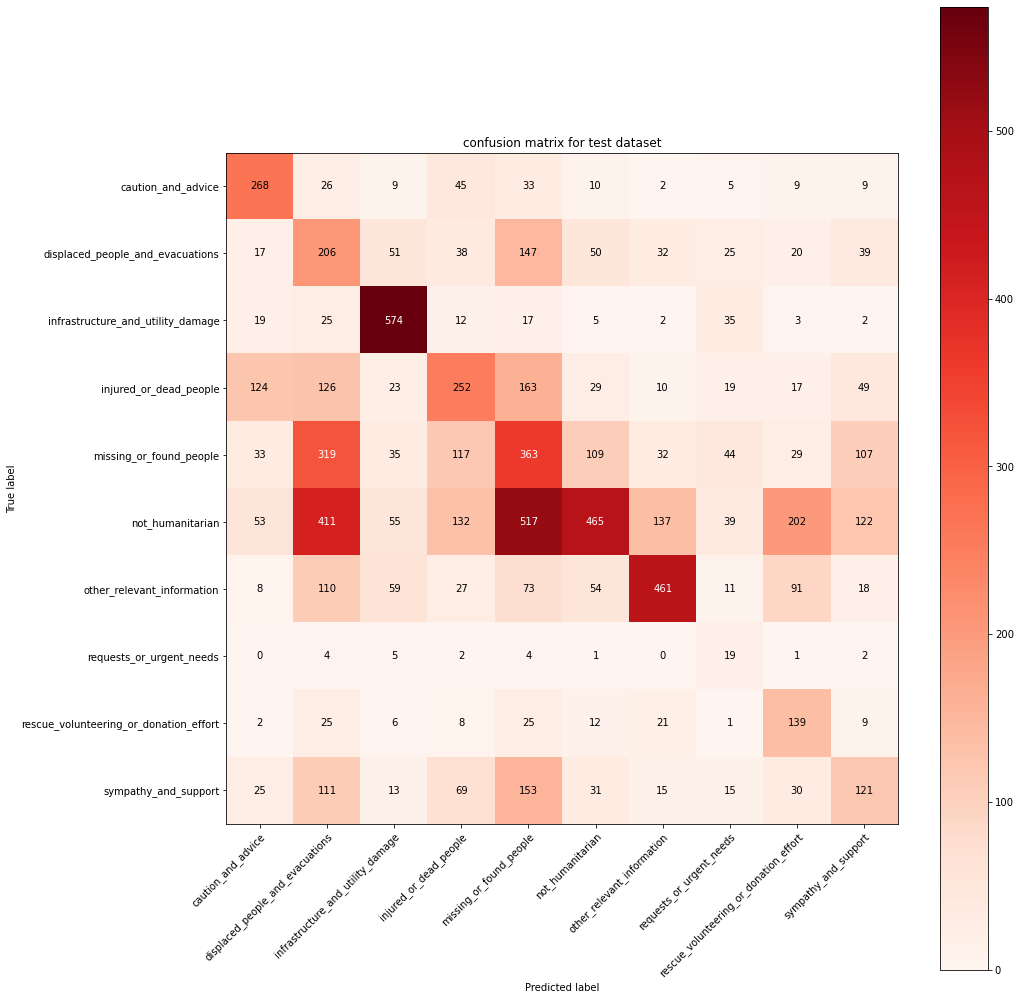

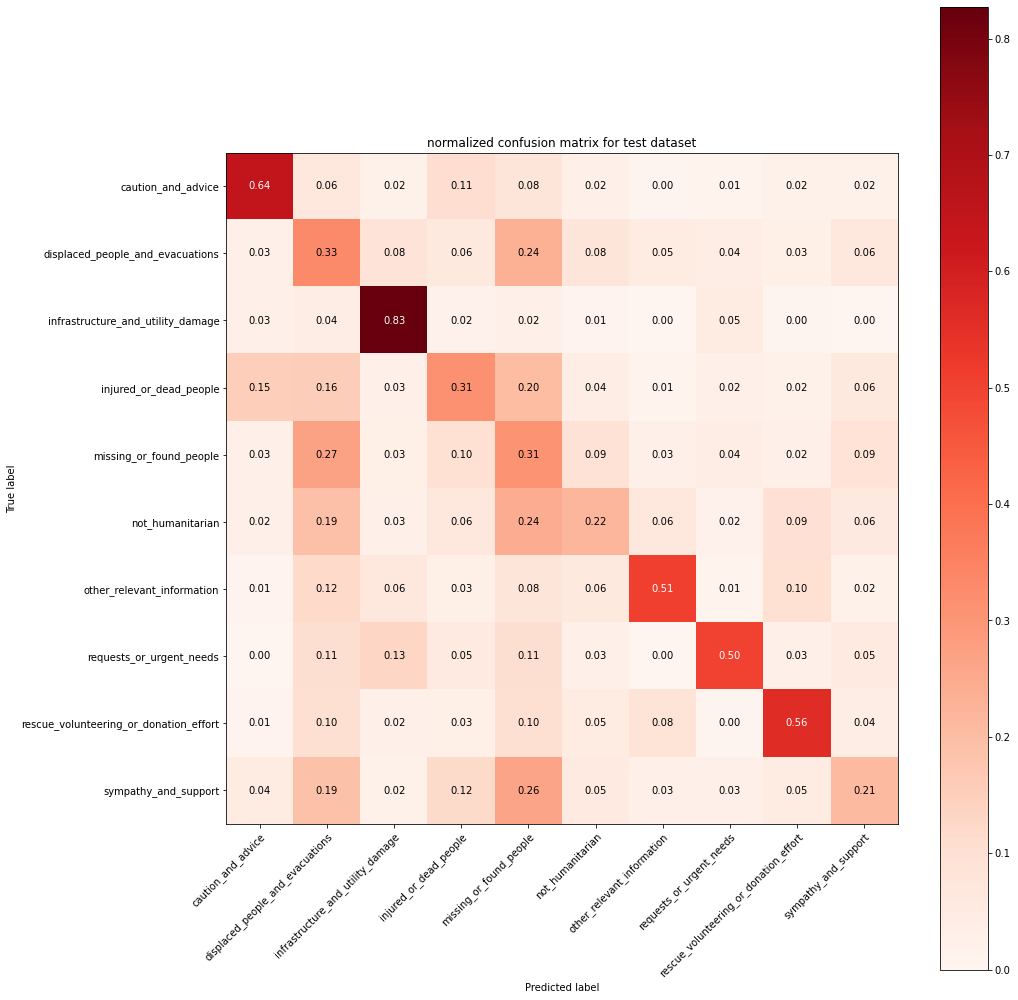

In [28]:
accuracy = accuracy_score(df_test['class_label_id'], prediction)
matthews = matthews_corrcoef(df_test['class_label_id'], prediction)

precisions = {}
recalls = {}
f1s = {}
aucrocs = {}

for i in range(len(label_name)):
    prediction_ = [1 if pred == i else 0 for pred in prediction]
    true_ = [1 if label == i else 0 for label in df_test['class_label_id']]
    f1s.update({label_name[i]: f1_score(true_, prediction_)})
    precisions.update({label_name[i]: precision_score(true_, prediction_)})
    recalls.update({label_name[i]: recall_score(true_, prediction_)})
    aucrocs.update({label_name[i]: roc_auc_score(true_, list(t.item() for t in prob[:, i]))})

metrics_dict = {'loss': loss, 'accuracy': accuracy, 'matthews coef': matthews, 'precision': precisions,
                     'recall': recalls, 'f1': f1s, 'aucroc': aucrocs}

pickle.dump(metrics_dict, open('evaluation_metrics', 'wb'))

cm = plot_confusion_matrix(list(df_test['class_label_id']), prediction, label_name, normalize=False,
                      path='test_confusion_matrix', title='confusion matrix for test dataset')
plt.savefig('test_confusion_matrix', format='png')
cm_norm = plot_confusion_matrix(list(df_test['class_label_id']), prediction, label_name, normalize=True,
                      path='test normalized_confusion_matrix', title='normalized confusion matrix for test dataset')
plt.savefig('test_normalized_confusion_matrix', format='png')

# print('loss: %.2f' % loss)
# print('accuracy: %.2f' % accuracy)
# print('matthews coef: %.2f' % matthews)
# for i in range(len(label_name)):
#     print('precision score for %s: %.2f' % (label_name[i], precisions[label_name[i]]))
#     print('recall score for %s: %.2f' % (label_name[i], recalls[label_name[i]]))
#     print('f1 score for %s: %.2f' % (label_name[i], f1s[label_name[i]]))
#     print('auc roc score for %s: %.2f' % (label_name[i], aucrocs[label_name[i]]))

In [ ]:
class LSTM(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(self).__init__()
        self.vocab_size, self.embedding_dim = weights_matrix.shape
        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding_layer.load_state_dict({'weight': weights_matrix})
        self.embedding_layer.weight.requires_grad = False
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        
    def forward(self, inp, hidden):
        return self.gru(self.embedding(inp), hidden)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [4]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Cuda Status on system is False


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
df = pd.read_csv('assets/df_cleaned.csv')

In [6]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        out = self.fc(hidden)
        return out

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
#     bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Text).squeeze(0)
#         print(predictions.shape, batch.Label.shape, model(batch.Text).shape)
        loss = criterion(predictions, batch.Label)
#         print(loss.shape)
        acc = binary_accuracy(predictions, batch.Label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
#         bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:

            predictions = model(batch.Text).squeeze(0)
            
            loss = criterion(predictions, batch.Label)
            
            acc = binary_accuracy(predictions, batch.Label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 2

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

In [ ]:
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [13]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [15]:
class ToyNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        
    def forward(self, inp, hidden):
        return self.gru(self.embedding(inp), hidden)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))